In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('cleanup.R')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [2]:
player <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")

sessions_clean <- sessions |>
    group_by(hashedEmail) |>
    summarize(sessions_count = n())

combined_data <- merge(player, sessions_clean, by = "hashedEmail")

player_filtered <- combined_data |>
   mutate(experience = as_factor(experience)) |>
   select(experience, played_hours, sessions_count)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
player_split <- initial_split(player_filtered, prop = 0.75, strata = experience)
player_train <- training(player_split)
player_test <- testing(player_split)

player_vfold <- vfold_cv(player_train, v = 5, strata = experience)

→ A | warning: ✖ No observations were detected in `truth` for level: Pro.
               ℹ Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





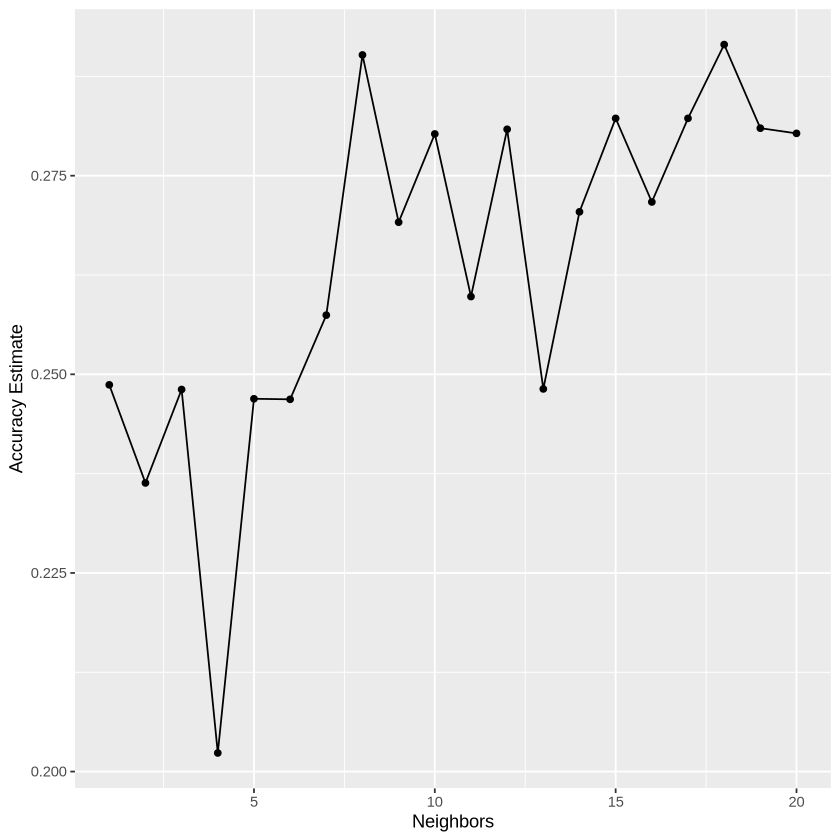

In [4]:
player_recipe <- recipe(experience ~ played_hours + sessions_count, data = player_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

knn_results <- workflow() |>
       add_recipe(player_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = player_vfold, grid = k_vals) |>
       collect_metrics()

accuracies <- knn_results |> 
       filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate")
accuracy_vs_k

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.27272727
kap,multiclass,-0.05459387


.pred_class,experience,played_hours,sessions_count
<fct>,<fct>,<dbl>,<int>
Amateur,Regular,1.5,2
Amateur,Pro,0.4,1
Amateur,Veteran,0.1,1
⋮,⋮,⋮,⋮
Amateur,Amateur,0.0,1
Amateur,Pro,1.2,1
Amateur,Amateur,0.1,1


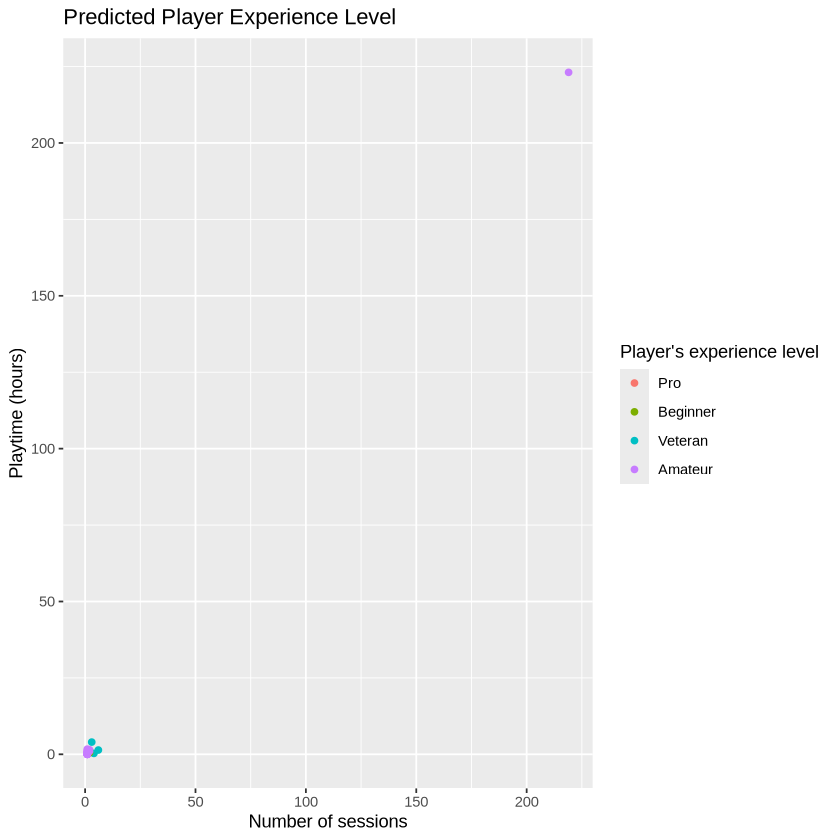

In [9]:
player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 8) |>
  set_engine("kknn") |>
  set_mode("classification")

player_fit <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(player_spec) |>
  fit(data = player_train)

player_test_predictions <- predict(player_fit, player_test) |>
   bind_cols(player_test)

player_test_predictions |>
  metrics(truth = experience, estimate = .pred_class)
player_test_predictions

player_plot <- ggplot(player_test_predictions, aes(x = sessions_count, y = played_hours, color = .pred_class)) +
   geom_point() +
   labs(x = "Number of sessions", y = "Playtime (hours)", color = "Player's experience level", title = "Predicting") +
    ggtitle("Predicted Player Experience Level")
player_plot

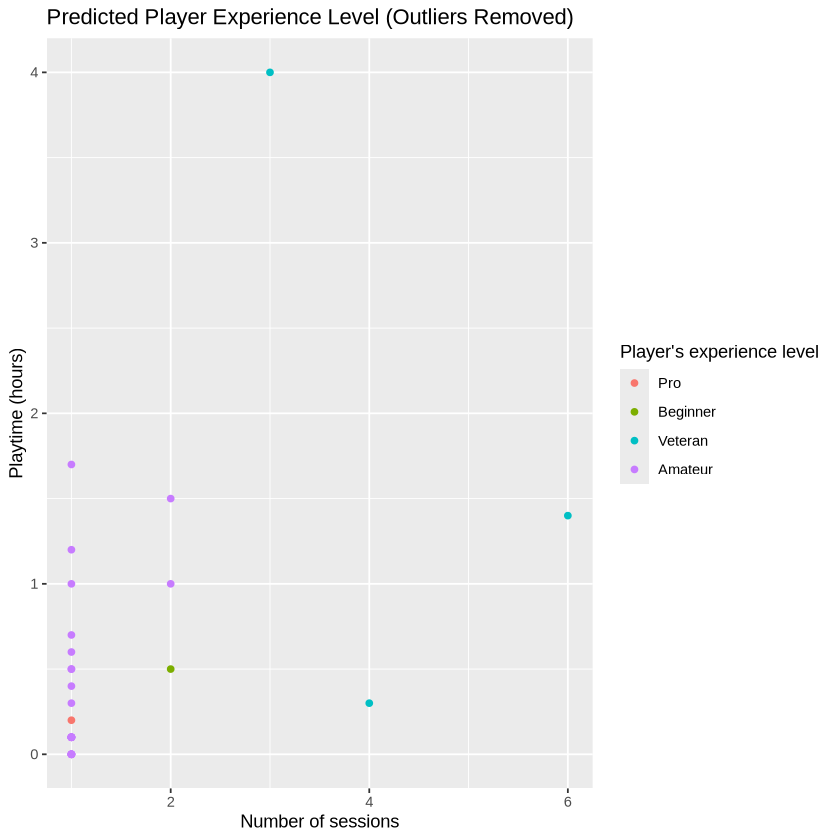

In [10]:
#Removing Outliers
player_test_predictions_no_outlier <- filter(player_test_predictions, sessions_count < 20)

player_plot_no_outlier <- ggplot(player_test_predictions_no_outlier, aes(x = sessions_count, y = played_hours, color = .pred_class)) +
   geom_point() +
   labs(x = "Number of sessions", y = "Playtime (hours)", color = "Player's experience level", title = "Predicting") +
    ggtitle("Predicted Player Experience Level (Outliers Removed)")
player_plot_no_outlier